In [177]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import pandas as pd
import numpy as np
import re
from scipy import sparse

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras import models
from keras import layers
from keras.utils.vis_utils import model_to_dot

from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble

from IPython.display import SVG

In [139]:
df_train = pd.read_csv('train.csv', encoding='utf8')
df_test = pd.read_csv('test.csv', encoding='utf8')

In [172]:
def parse_df(df):
    match_numbers = re.compile(r'[0-9]+', flags=re.IGNORECASE)
    df['comment_text'] = df.comment_text.str.replace(match_numbers, 'num')
    df['comment_text'] = df.comment_text.str.replace('[\n"]', ' ')
    
    df['comment_length'] = df['comment_text'].apply(lambda r: len(r.split(' ')))
    df['nb_unique_words'] = df['comment_text'].apply(lambda r: len(set(r.split(' '))))
    df['unique_words_ratio'] = df['nb_unique_words'] / df['comment_length'].astype(float)
    
    df['nb_!'] = df['comment_text'].apply(lambda r: r.count('!'))
    df['nb_uppercase'] = df['comment_text'].apply(lambda r: len(re.findall('[A-Z\d]+', r)))
    
    return df

In [145]:
df_train = parse_df(df_train)

/home/eric/code/venvs/data3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Linear Model

In [173]:
v = TfidfVectorizer(ngram_range=(1, 2),
                    max_features=100000,
                    stop_words='english')

X = sparse.hstack([v.fit_transform(df_train['comment_text']),
                   StandardScaler().fit_transform(df_train['nb_unique_words'].values.reshape(-1, 1)),
                   StandardScaler().fit_transform(df_train['nb_!'].values.reshape(-1, 1)),
                   StandardScaler().fit_transform(df_train['unique_words_ratio'].values.reshape(-1, 1)),
                   StandardScaler().fit_transform(df_train['nb_uppercase'].values.reshape(-1, 1)),
                   StandardScaler().fit_transform(df_train['comment_length'].values.reshape(-1, 1)),
                  ])
y = df_train['toxic']

clf = linear_model.LogisticRegression()

np.mean(cross_val_score(clf, X, y, scoring='roc_auc'))

/home/eric/code/venvs/data3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.9689131599600443

## Gradient Boosting

In [168]:
v = TfidfVectorizer(ngram_range=(1, 1),
                    max_features=10000,
                    stop_words='english')

X = sparse.hstack([v.fit_transform(df_train['comment_text']),
                   # df_train['nb_unique_words'].values.reshape(-1, 1),
                   df_train['nb_!'].values.reshape(-1, 1),
                   df_train['unique_words_ratio'].values.reshape(-1, 1),
                   df_train['nb_uppercase'].values.reshape(-1, 1),
                   df_train['comment_length'].values.reshape(-1, 1),
                  ])
y = df_train['toxic']


clf = ensemble.GradientBoostingClassifier()

np.mean(cross_val_score(clf, X, y, scoring='roc_auc'))

0.911372003836853

## GRU

In [38]:
X = pad_sequences(df_train['comment_text'].head(10000).map(lambda r: one_hot(r, 100000)), maxlen=300)
y = df_train['toxic'].head(10000)

X_train, X_val, y_train, y_val = train_test_split(X, y)

In [39]:
model = Sequential()
model.add(Embedding(input_dim=100000,
                    output_dim=128,
                    input_shape=(300,)))
model.add(GRU(128))
model.add(Dropout(0.4))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [40]:
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=2)

Train on 7500 samples, validate on 2500 samples
Epoch 1/2
7500/7500 [==============================] - 60s 8ms/step - loss: 0.2558 - acc: 0.9187 - val_loss: 0.1761 - val_acc: 0.9392
Epoch 2/2
7500/7500 [==============================] - 59s 8ms/step - loss: 0.0984 - acc: 0.9641 - val_loss: 0.2142 - val_acc: 0.9280


In [41]:
roc_auc_score(model.predict_classes(X_val), y_val)

0.8142222222222223

## Mixing Inputs

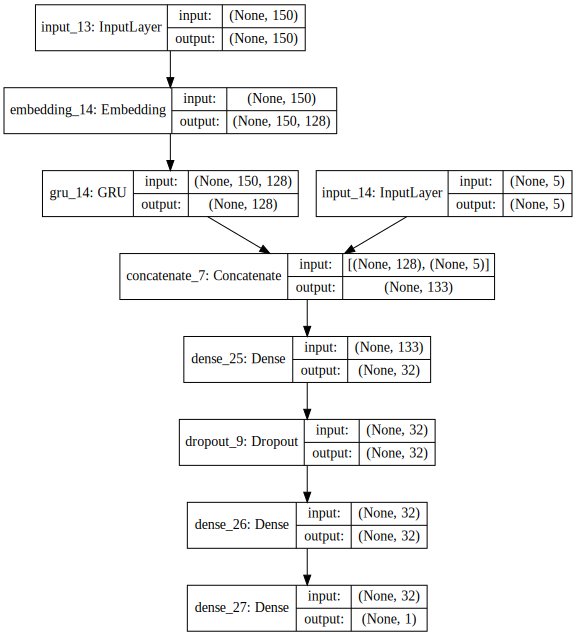

In [202]:
i_text = layers.Input(shape=(150,), dtype='int32')

e_text = layers.Embedding(input_dim=100000,
                          output_dim=128,
                          input_shape=(150,))(i_text)

gru_text = layers.GRU(128)(e_text)

i_numerical = layers.Input(shape=(5,), dtype='float32')

c = layers.concatenate([gru_text, i_numerical])
h = layers.Dense(32, activation='relu')(c)
h = layers.Dropout(0.3)(h)
h = layers.Dense(32, activation='relu')(h)
o = layers.Dense(1, activation='sigmoid')(h)

model = models.Model(inputs=[i_text, i_numerical],
                     outputs=[o])

model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [204]:
df = df_train.sample(frac=1)
print(len(df))
train, val = train_test_split(df)

def parse_df_2(df):
    x_text = pad_sequences(df['comment_text'].map(lambda r: one_hot(r, 100000)), maxlen=150)

    x_numerical = np.hstack([df['nb_unique_words'].values.reshape(-1, 1),
                             df['nb_!'].values.reshape(-1, 1),
                             df['unique_words_ratio'].values.reshape(-1, 1),
                             df['nb_uppercase'].values.reshape(-1, 1),
                             df['comment_length'].values.reshape(-1, 1),])
    
    return [x_text, x_numerical]

model.fit(parse_df_2(train),
          train['toxic'],
          epochs=2)

159571
Epoch 1/2
119678/119678 [==============================] - 719s 6ms/step - loss: 0.1690 - acc: 0.9459
Epoch 2/2
119678/119678 [==============================] - 668s 6ms/step - loss: 0.1041 - acc: 0.9640


In [205]:
roc_auc_score(list(map(lambda r: 1 if r > 0.5 else 0, model.predict(parse_df_2(val)))),
              val['toxic'])

0.9175305551898955

## Pre trained embeddings

In [207]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=50000)
tokenizer.fit_on_texts(train['comment_text'])
sequences = tokenizer.texts_to_sequences(train['comment_text'])

word_index = tokenizer.word_index
print('Found {0} unique tokens.'.format(len(word_index)))

data = pad_sequences(sequences, maxlen=150)

/home/eric/code/venvs/data3/lib/python3.5/site-packages/keras/preprocessing/text.py:157: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 167461 unique tokens.


In [222]:
embeddings_index = {}

f = open(os.path.join('/home/eric/data', 'glove.42B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    if word in word_index:
        embeddings_index[word] = coefs

f.close()

print('Found {0} word vectors.'.format(len(embeddings_index)))

Found 104419 word vectors.


In [235]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [239]:
from keras.layers import Embedding

embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=300,
                            weights=[embedding_matrix],
                            input_length=150,
                            trainable=False)

In [260]:
x_train, x_val, y_train, y_val = train_test_split(np.asarray(data), train['toxic'])

print(x_train.shape,
      x_val.shape,
      y_train.shape,
      y_val.shape)

(89758, 150) (29920, 150) (89758,) (29920,)


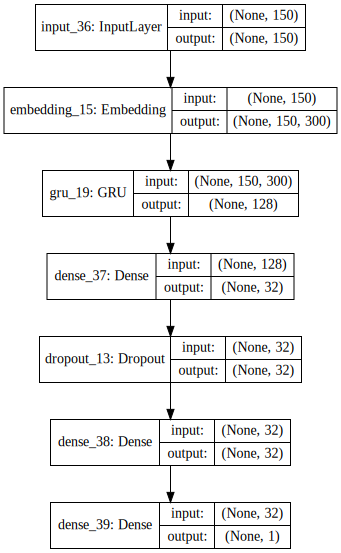

In [264]:
sequence_input = layers.Input(shape=(150,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
gru_sequences = layers.GRU(128)(embedded_sequences)

numerical_input = layers.Input(shape=(5,), dtype='float32')

h = layers.Dense(32, activation='relu')(gru_sequences)
h = layers.Dropout(0.3)(h)
h = layers.Dense(32, activation='relu')(h)
preds = layers.Dense(1, activation='sigmoid')(h)

model = models.Model(inputs=[sequence_input],
                     outputs=[preds])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model.fit(x_train,
          y_train,
          validation_data=(x_val, y_val),
          epochs=2,
          batch_size=128)

Train on 89758 samples, validate on 29920 samples
Epoch 1/2
 8320/89758 [=>............................] - ETA: 2:27 - loss: 0.2858 - acc: 0.9023